<a href="https://colab.research.google.com/github/AeroEng16/FootballAnalysis/blob/main/lineDetectionAndHomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [1]:

import math
import plotly.express as px
import pandas as pd
from google.colab.patches import cv2_imshow
try:
  import supervision as sv
  from inference import get_model
except ImportError:
  #!pip install inference
  !pip install supervision
  !pip install inference-gpu
  import supervision as sv
  from inference import get_model
import cv2
import numpy as np
from PIL import Image
import os
import collections
from tqdm import tqdm
#LOOK AT CHANGING TO INFERENCE ON GPU


## Pitch Vertex Labels

Figure out how pitch config works and recreate alongside template image

In [2]:


!pip install -q git+https://github.com/roboflow/sports.git


from dataclasses import dataclass, field
from typing import List, Tuple


@dataclass
class SoccerPitchConfiguration:
    width: int = 7000  # [cm]
    length: int = 12000  # [cm]
    penalty_box_width: int = 4100  # [cm]
    penalty_box_length: int = 2015  # [cm]
    goal_box_width: int = 1832  # [cm]
    goal_box_length: int = 550  # [cm]
    centre_circle_radius: int = 915  # [cm]
    penalty_spot_distance: int = 1100  # [cm]

    @property
    def vertices(self) -> List[Tuple[int, int]]:
        return [
            (0, 0),  # 1
            (0, (self.width - self.penalty_box_width) / 2),  # 2
            (0, (self.width - self.goal_box_width) / 2),  # 3
            (0, (self.width + self.goal_box_width) / 2),  # 4
            (0, (self.width + self.penalty_box_width) / 2),  # 5
            (0, self.width),  # 6
            (self.goal_box_length, (self.width - self.goal_box_width) / 2),  # 7
            (self.goal_box_length, (self.width + self.goal_box_width) / 2),  # 8
            (self.penalty_spot_distance, self.width / 2),  # 9
            (self.penalty_box_length, (self.width - self.penalty_box_width) / 2),  # 10
            (self.penalty_box_length, (self.width - self.goal_box_width) / 2),  # 11
            (self.penalty_box_length, (self.width + self.goal_box_width) / 2),  # 12
            (self.penalty_box_length, (self.width + self.penalty_box_width) / 2),  # 13
            (self.length / 2, 0),  # 14
            (self.length / 2, self.width / 2 - self.centre_circle_radius),  # 15
            (self.length / 2, self.width / 2 + self.centre_circle_radius),  # 16
            (self.length / 2, self.width),  # 17
            (
                self.length - self.penalty_box_length,
                (self.width - self.penalty_box_width) / 2
            ),  # 18
            (
                self.length - self.penalty_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 19
            (
                self.length - self.penalty_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 20
            (
                self.length - self.penalty_box_length,
                (self.width + self.penalty_box_width) / 2
            ),  # 21
            (self.length - self.penalty_spot_distance, self.width / 2),  # 22
            (
                self.length - self.goal_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 23
            (
                self.length - self.goal_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 24
            (self.length, 0),  # 25
            (self.length, (self.width - self.penalty_box_width) / 2),  # 26
            (self.length, (self.width - self.goal_box_width) / 2),  # 27
            (self.length, (self.width + self.goal_box_width) / 2),  # 28
            (self.length, (self.width + self.penalty_box_width) / 2),  # 29
            (self.length, self.width),  # 30
            (self.length / 2 - self.centre_circle_radius, self.width / 2),  # 31
            (self.length / 2 + self.centre_circle_radius, self.width / 2),  # 32
        ]

    edges: List[Tuple[int, int]] = field(default_factory=lambda: [
        (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (7, 8),
        (10, 11), (11, 12), (12, 13), (14, 15), (15, 16),
        (16, 17), (18, 19), (19, 20), (20, 21), (23, 24),
        (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
        (1, 14), (2, 10), (3, 7), (4, 8), (5, 13), (6, 17),
        (14, 25), (18, 26), (23, 27), (24, 28), (21, 29), (17, 30)
    ])

    labels: List[str] = field(default_factory=lambda: [
        "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
        "11", "12", "13", "15", "16", "17", "18", "20", "21", "22",
        "23", "24", "25", "26", "27", "28", "29", "30", "31", "32",
        "14", "19"
    ])

    colors: List[str] = field(default_factory=lambda: [
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#00BFFF", "#00BFFF", "#00BFFF", "#00BFFF", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#00BFFF", "#00BFFF"
    ])

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.8 MB/s eta 0:00:00


In [3]:
CONFIG = SoccerPitchConfiguration()
CONFIG.vertices

[(0, 0),
 (0, 1450.0),
 (0, 2584.0),
 (0, 4416.0),
 (0, 5550.0),
 (0, 7000),
 (550, 2584.0),
 (550, 4416.0),
 (1100, 3500.0),
 (2015, 1450.0),
 (2015, 2584.0),
 (2015, 4416.0),
 (2015, 5550.0),
 (6000.0, 0),
 (6000.0, 2585.0),
 (6000.0, 4415.0),
 (6000.0, 7000),
 (9985, 1450.0),
 (9985, 2584.0),
 (9985, 4416.0),
 (9985, 5550.0),
 (10900, 3500.0),
 (11450, 2584.0),
 (11450, 4416.0),
 (12000, 0),
 (12000, 1450.0),
 (12000, 2584.0),
 (12000, 4416.0),
 (12000, 5550.0),
 (12000, 7000),
 (5085.0, 3500.0),
 (6915.0, 3500.0)]

## Detect Players and Ball and Use detected keypoints to transform

In [5]:


#Setup class to conduct the homography transformation

class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        if source.shape != target.shape:
            raise ValueError(
                "Source and target must have the same shape.")
        if source.shape[1] != 2:
            raise ValueError(
                "Source and target points must be 2D coordinates.")

        source = source.astype(np.float32)
        target = target.astype(np.float32)

        self.m, _ = cv2.findHomography(source, target)
        if self.m is None:
            raise ValueError(
                "Homography matrix could not be calculated.")

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        if points.shape[1] != 2:
            raise ValueError("Points must be 2D coordinates.")

        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1, 2).astype(np.float32)


### Initiliase the three models used

In [6]:

model = get_model(
    model_id="football-field-detection-f07vi/14",
    api_key="Sjv2KA46fn0Ksxphg6NV"
)

ballModel = get_model(
    model_id="football-ball-detection-rejhg/4",
    api_key="Sjv2KA46fn0Ksxphg6NV"
)

playerModel = get_model(
    model_id="football-players-detection-3zvbc/12",
    api_key="Sjv2KA46fn0Ksxphg6NV"
)



### Calculate the detections and kit color for each frame

In [51]:
# Loop through frames, identifying objects and moving to flat pitch view view
#homography transform and saving in df
vid = cv2.VideoCapture("/content/drive/MyDrive/ML/FootballAnalysis/08fd33_4.mp4")
#ADD HOMOGRAPHY TRANSFORM AND DF STORING OF DATA

NEED TO FIX SHIRT COLOR DETECTION

vidLength = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

## Initiliase dataframe to store detections

df = pd.DataFrame(data=None,columns=["Frame","Ball Location","PlayerDicts"])

i=-1;

kits_colors = []

for i in tqdm(range(vidLength)):
#while True:

  if i > 1000:
    break
  if ret == False:
    break
  ret, frame = vid.read()
  i+=1
  if i ==0:
    ### First calculate the color of the grass

    # Convert image to HSV color space
    img = frame.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define a large range of green color in HSV
    lower_green = np.array([30, 40, 40])
    upper_green = np.array([80, 255, 255])

    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Calculate the mean value of the pixels that are not masked
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    grass_color = cv2.mean(img, mask=mask)
    grass_color = grass_color[:3]
    #print("Grass BGR color: ", grass_color)


  #image = cv2.imread("test.png")
  image = frame
  # KeyPointDetections
  result = model.infer(image, confidence=0.3)[0]

  keypoints = sv.KeyPoints.from_inference(result)

  filter = keypoints.confidence[0] > 0.5

  keypoints.xy = keypoints.xy[0][filter][np.newaxis]
  keypoints.confidence = keypoints.confidence[0][filter][np.newaxis]

  vertex_annotator = sv.VertexAnnotator(radius=12)
  annotated_image = vertex_annotator.annotate(image.copy(), keypoints)

  transformer = ViewTransformer(
      target=np.array(CONFIG.vertices)[filter].astype(np.float32),
      source=np.array(keypoints.xy[0].astype(np.float32),)
  )

  #Ball Detection

  resultBall = ballModel.infer(image, confidence=0.5)[0]

  detectionsBall = sv.Detections.from_inference(resultBall)

  EllipseAnnotator_annotatorBall = sv.EllipseAnnotator(thickness=2)
  annotated_imageBall = EllipseAnnotator_annotatorBall.annotate(annotated_image.copy(), detectionsBall)

  xyBall = detectionsBall.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

  xyBall = transformer.transform_points(points=xyBall)


  #Player Detection

  resultPlayer = playerModel.infer(image, confidence=0.7)[0]

  detectionsPlayer = sv.Detections.from_inference(resultPlayer)

  xyPlayers = detectionsPlayer.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

  EllipseAnnotator_annotatorPlayer = sv.EllipseAnnotator(thickness=2)
  annotated_imagePlayer = EllipseAnnotator_annotatorPlayer.annotate(annotated_imageBall.copy(), detectionsPlayer)
  im = Image.fromarray(annotated_imagePlayer)
  #im.save("annotatedImage" + str(i) +".png")

  ### Work out kit color


#ADD A CHECK THAT IF ALL OF IMAGE IS MASKED THEN SET KIT COLOUR TO GREEN (or better way of dealing with this)

  filterPlayer = detectionsPlayer.data["class_name"]  == "player"
  filterGk = detectionsPlayer.data["class_name"]  == "goalkeeper"


  xyPlayers = xyPlayers[filterPlayer]
  xyPlayers = transformer.transform_points(points=xyPlayers)

  playerBoxes = detectionsPlayer.xyxy[filterPlayer]
  gkBoxes = detectionsPlayer.xyxy[filterGk]

  grass_hsv = cv2.cvtColor(np.uint8([[list(grass_color)]]), cv2.COLOR_BGR2HSV)
  playerDict = {}
  for counter,box in enumerate(playerBoxes):

      x1, y1, x2, y2 = map(int, box)
      player_img = frame[y1: y2, x1: x2]

      # Convert image to HSV color space
      hsv = cv2.cvtColor(player_img, cv2.COLOR_BGR2HSV)

      # Define range of green color in HSV
      lower_green = np.array([grass_hsv[0, 0, 0] - 10, 40, 40])
      upper_green = np.array([grass_hsv[0, 0, 0] + 10, 255, 255])

      # Threshold the HSV image to get only green colors
      mask = cv2.inRange(hsv, lower_green, upper_green)
      # Bitwise-AND mask and original image
      mask = cv2.bitwise_not(mask)

      upper_mask = np.zeros(player_img.shape[:2], np.uint8)
      upper_mask[0:player_img.shape[0]//2, 0:player_img.shape[1]] = 255
      mask = cv2.bitwise_and(mask, upper_mask)

      masked_img = cv2.bitwise_and(player_img, player_img, mask=mask)

      # Check for mask where over 90% of bounding box is detected as green
      greenKitTest = collections.Counter(mask.flatten())
      if greenKitTest[255]/(greenKitTest[255]+greenKitTest[0]) > 0.9:
        player_kit_color = np.array(grass_hsv[0,0])
      else:
        player_kit_color = np.array(cv2.mean(player_img, mask=mask)[:3])

      kits_colors.append(player_kit_color)
      demo_color = np.repeat(player_kit_color[np.newaxis, ...], 50, axis=0)
      demo_color = np.repeat(demo_color[np.newaxis, ...], 50, axis=0)

      playerDict[counter] = {"kitColor": player_kit_color,"location": xyPlayers[counter]}

      #CHECK THE LOCATION ABOVE IS THE BOTTOM MIDDLE COORDINATE

  ## Add data for current frame to df

  df.loc[i]= [i, xyBall, playerDict]

df.to_csv("transformedData.csv")



Exception in thread Thread-12 (_usage_sender):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/inference/usage_tracking/collector.py", line 450, in _usage_sender
    self._flush_queue()
  File "/usr/local/lib/python3.10/dist-packages/inference/usage_tracking/collector.py", line 458, in _flush_queue
    merged_payloads: APIKeyUsage = zip_usage_payloads(
  File "/usr/local/lib/python3.10/dist-packages/inference/usage_tracking/payload_helpers.py", line 123, in zip_usage_payloads
    merged_api_key_payload[resource_usage_key] = merge_usage_dicts(
  File "/usr/local/lib/python3.10/dist-packages/inference/usage_tracking/payload_helpers.py", line 21, in merge_usage_dicts
    raise ValueError("Cannot merge usage for different resource IDs")
ValueError: Cannot merge us

InvalidImageTypeDeclared: NumPy image type is not supported in this configuration of `inference`.

In [52]:
df.to_csv("transformedData.csv")


## Use K-means clustering to determine what team each player detection belongs to

### Next mask each image of a player detection and by removing the grass color store the kit colours for each image

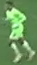

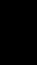

Counter({0: 2405})
Player Kit Color: 


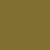

####################################################################################################


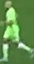

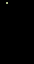

Counter({0: 2172, 255: 4})
Player Kit Color: 


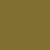

####################################################################################################


Counter({0: 891, 255: 184})
Player Kit Color: 


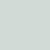

####################################################################################################


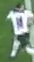

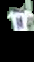

Counter({0: 1465, 255: 643})
Player Kit Color: 


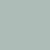

####################################################################################################


Counter({0: 2108})
Player Kit Color: 


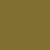

####################################################################################################


Counter({0: 1522, 255: 548})
Player Kit Color: 


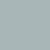

####################################################################################################


Counter({0: 938, 255: 304})
Player Kit Color: 


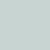

####################################################################################################


Counter({0: 1304, 255: 262})
Player Kit Color: 


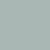

####################################################################################################


Counter({0: 925})
Player Kit Color: 


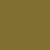

####################################################################################################


Counter({0: 1150})
Player Kit Color: 


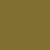

####################################################################################################


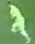

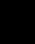

Counter({0: 1540})
Player Kit Color: 


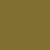

####################################################################################################


Counter({0: 1220, 255: 388})
Player Kit Color: 


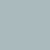

####################################################################################################


Counter({0: 1456})
Player Kit Color: 


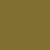

####################################################################################################


Counter({0: 917, 255: 475})
Player Kit Color: 


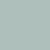

####################################################################################################


Counter({0: 733, 255: 296})
Player Kit Color: 


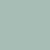

####################################################################################################


Counter({0: 2092, 255: 8})
Player Kit Color: 


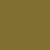

####################################################################################################


Counter({0: 1566})
Player Kit Color: 


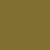

####################################################################################################


Counter({0: 1090, 255: 451})
Player Kit Color: 


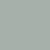

####################################################################################################


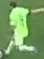

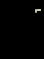

Counter({0: 2580, 255: 16})
Player Kit Color: 


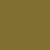

####################################################################################################


Counter({0: 1057, 255: 320})
Player Kit Color: 


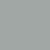

####################################################################################################


In [50]:

#ADD A CHECK THAT IF ALL OF IMAGE IS MASKED THEN SET KIT COLOUR TO GREEN (or better way of dealing with this)

vid = cv2.VideoCapture("/content/drive/MyDrive/ML/FootballAnalysis/08fd33_4.mp4")
#ADD HOMOGRAPHY TRANSFORM AND DF STORING OF DATA

## Initiliase dataframe to store detections

#for i in range(749):
#  ret, frame = vid.read()

filterPlayer = detectionsPlayer.data["class_name"]  == "player"
filterGk = detectionsPlayer.data["class_name"]  == "goalkeeper"

playerBoxes = detectionsPlayer.xyxy[filterPlayer]
gkBoxes = detectionsPlayer.xyxy[filterGk]

kits_colors = []
grass_hsv = cv2.cvtColor(np.uint8([[list(grass_color)]]), cv2.COLOR_BGR2HSV)

for counter,box in enumerate(playerBoxes):

    x1, y1, x2, y2 = map(int, box)
    player_img = frame[y1: y2, x1: x2]
    if counter <20:
      cv2_imshow(player_img)

    # Convert image to HSV color space
    hsv = cv2.cvtColor(player_img, cv2.COLOR_BGR2HSV)

    # Define range of green color in HSV
    lower_green = np.array([grass_hsv[0, 0, 0] - 10, 40, 40])
    upper_green = np.array([grass_hsv[0, 0, 0] + 10, 255, 255])

    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)
    # Bitwise-AND mask and original image
    mask = cv2.bitwise_not(mask)

    upper_mask = np.zeros(player_img.shape[:2], np.uint8)
    upper_mask[0:player_img.shape[0]//2, 0:player_img.shape[1]] = 255
    mask = cv2.bitwise_and(mask, upper_mask)

    masked_img = cv2.bitwise_and(player_img, player_img, mask=mask)
    if counter <20:
      cv2_imshow(masked_img)

    # Check for mask where over 90% of bounding box is detected as green
    greenKitTest = collections.Counter(mask.flatten())
    print(greenKitTest)
    if len(greenKitTest.keys()) ==1 or greenKitTest[0]/(greenKitTest[255]+greenKitTest[0]) > 0.95:
      player_kit_color = np.array(grass_hsv[0,0])
    else:
      player_kit_color = np.array(cv2.mean(player_img, mask=mask)[:3])

    kits_colors.append(player_kit_color)

    if counter <20:
      print("Player Kit Color: ")
    demo_color = np.repeat(player_kit_color[np.newaxis, ...], 50, axis=0)
    demo_color = np.repeat(demo_color[np.newaxis, ...], 50, axis=0)
    if counter <20:
      cv2_imshow(demo_color)
      print('#' * 100)



### Finally, based on the kit colors, calculate a k-means clustering to place the player detections in the relevant team

In [53]:
FIGURE OUT KMEANS CLUSTERING FOR KIT COLORS


from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

kits_kmeans = KMeans(n_clusters=2)
kits_kmeans.fit(kits_colors);

kits_colors = np.array(kits_colors)

import plotly.express as px

fig = px.scatter_3d(
    x=kits_colors[:, 2],
    y=kits_colors[:, 1],
    z=kits_colors[:, 0],
    range_x=[0, 255],
    range_y=[0, 255],
    range_z=[0, 255],
    title="Kits Colors"
    )
fig.update_traces(marker_size = 10)
fig.update_traces(marker_color = list(map(lambda e: (e[2], e[1], e[0]), kits_colors)))

fig.add_scatter3d(
    x=[kits_kmeans.cluster_centers_[0, 2]],
    y=[kits_kmeans.cluster_centers_[0, 1]],
    z=[kits_kmeans.cluster_centers_[0, 0]],
)

fig.add_scatter3d(
    x=[kits_kmeans.cluster_centers_[1, 2]],
    y=[kits_kmeans.cluster_centers_[1, 1]],
    z=[kits_kmeans.cluster_centers_[1, 0]],
)

for i, d in enumerate(fig.data[-2:]):
  d.marker.symbol='cross'
  d.marker.color=kits_kmeans.cluster_centers_[i, ::-1]

fig.show()



### Assign players from first frame to each frame and store in associated dataframe

In [ ]:
kits_kmeans.predict(player_kit_color)

team1Player = [x for index,x in enumerate(xyPlayers) if kits_kmeans.labels_[index] == 1 ]
team2Player = [x for index,x in enumerate(xyPlayers) if kits_kmeans.labels_[index] == 0 ]

team1Player,team2Player

([array([7449.5557, 4314.738 ], dtype=float32),
  array([5465.4497, 4521.5845], dtype=float32),
  array([5714.7246, 4348.097 ], dtype=float32),
  array([8172.034, 4208.535], dtype=float32),
  array([5795.61  , 1840.1903], dtype=float32),
  array([7600.63  , 7014.6597], dtype=float32),
  array([6287.9966, 5333.926 ], dtype=float32),
  array([6905.021, 3807.011], dtype=float32),
  array([5797.1772, 6152.091 ], dtype=float32),
  array([6805.554 , 5793.7075], dtype=float32),
  array([8281.604 , 3062.7812], dtype=float32),
  array([8092.1426 ,  379.82413], dtype=float32),
  array([7289.1816, 6358.754 ], dtype=float32)],
 [array([8357.738 , 4418.3096], dtype=float32),
  array([8454.083 , 3793.8523], dtype=float32),
  array([8438.562 , 6028.6353], dtype=float32),
  array([7331.7075, 3034.278 ], dtype=float32),
  array([6136.512, 6021.809], dtype=float32),
  array([8262.789 , 2190.7744], dtype=float32)])

## Loop through rest of frames and assign bounding boxes to each team

In [ ]:
for counter,box in enumerate(playerBoxes):

  x1, y1, x2, y2 = map(int, box)
  player_img = frame[y1: y2, x1: x2]

  # Convert image to HSV color space
  hsv = cv2.cvtColor(player_img, cv2.COLOR_BGR2HSV)

  # Define range of green color in HSV
  lower_green = np.array([grass_hsv[0, 0, 0] - 10, 40, 40])
  upper_green = np.array([grass_hsv[0, 0, 0] + 10, 255, 255])

  # Threshold the HSV image to get only green colors
  mask = cv2.inRange(hsv, lower_green, upper_green)
  # Bitwise-AND mask and original image
  mask = cv2.bitwise_not(mask)

  upper_mask = np.zeros(player_img.shape[:2], np.uint8)
  upper_mask[0:player_img.shape[0]//2, 0:player_img.shape[1]] = 255
  mask = cv2.bitwise_and(mask, upper_mask)

  masked_img = cv2.bitwise_and(player_img, player_img, mask=mask)

  # Check for mask where over 90% of bounding box is detected as green
  greenKitTest = collections.Counter(mask.flatten())
  if greenKitTest[255]/(greenKitTest[255]+greenKitTest[0]) > 0.9:
    player_kit_color = np.array(grass_hsv[0,0])
  else:
    player_kit_color = np.array(cv2.mean(player_img, mask=mask)[:3])




In [28]:
import os
def save():
    os.system("ffmpeg -r 30 -i annotatedImage%01d.png -vcodec mpeg4 -y movie.mp4")

save()

## Own trained model via transfer learning

In [ ]:
try:
  from ultralytics import YOLO
except ModuleNotFoundError:
  !pip install ultralytics
  from ultralytics import YOLO

# Load a pretrained YOLO11n model
modelPlayers = YOLO("/content/drive/MyDrive/ML/FootballAnalysis/Models/bestFootballYoloSoFar.pt")

# Run inference on 'bus.jpg' with arguments
modelPlayers.predict("test.png", save=True, conf=0.5)

modelBall = YOLO("/content/drive/MyDrive/ML/FootballAnalysis/Models/bestBallSoFar_0409.pt")

modelBall.predict("test.png", save=True, conf=0.1)


image 1/1 /content/test.png: 384x640 23 players, 1 referee, 315.0ms
Speed: 4.0ms preprocess, 315.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict

image 1/1 /content/test.png: 384x640 2 balls, 5236.3ms
Speed: 8.5ms preprocess, 5236.3ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'ball'}
 obb: None
 orig_img: array([[[105, 146, 100],
         [ 98, 139,  93],
         [101, 150,  97],
         ...,
         [ 82,  92, 100],
         [ 85,  95, 103],
         [ 87,  97, 105]],
 
        [[104, 145,  99],
         [105, 146, 100],
         [114, 163, 110],
         ...,
         [ 87,  97, 105],
         [ 89,  99, 107],
         [ 90, 100, 108]],
 
        [[101, 150,  97],
         [110, 159, 106],
         [115, 172, 114],
         ...,
         [ 88,  98, 106],
         [ 90, 100, 108],
         [ 92, 102, 110]],
 
        ...,
 
        [[ 78, 103,  74],
         [ 78, 103,  74],
         [ 78, 103,  74],
         ...,
         [ 43,  47,  30],
         [ 44,  48,  31],
         [ 44,  48,  31]],
 
        [[ 78, 103,  74],
         [ 78, 103,  74],
         [ 78, 103,  74],
         ...,
         [ 55,  56, 